<a href="https://colab.research.google.com/github/j1ayizhao/datascienceA2/blob/main/JiayZhaoUnit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You need to submit a .ipynb file with the first four letters of one first name, the first four letters of one last name, and U3proj.

Ex.

A student named Avy Aguacate Avocado Palta will submit a file named "Avy_AvocU3proj.ipynb", since she normally just goes by Avy, and, when pressed, reports Avocado as her last name. The " _ " after "Avy" serves as the fourth "letter" in her first name.

Ex2.

Army Armadillo will submit a file named "ArmyArmaU2proj.ipynb"

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [ ]:
url_basketball= 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'
basketball_data = pd.read_csv(url_basketball, dtype = {'Pos':'category'})


basketball_data = basketball_data[['Player', 'Pos', 'TRB']]

In [ ]:
basketball_data

,Player,Pos,TRB
0,Precious Achiuwa,PF-C,487
1,Bam Adebayo,C,737
2,Ochai Agbaji,SG,216
3,Santi Aldama,PF,352
4,Nickeil Alexander-Walker,SG,167
...,...,...,...
567,Thaddeus Young,PF,103
568,Trae Young,PG,149
569,Omer Yurtseven,C,208
570,Cody Zeller,C,112


In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball_data.Pos.cat.codes.values

#an array of the strings that represent positions
pos_codes = basketball_data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bskt_coords = {"pos": pos_codes}

## Model

To build my first model, I wanted to first visualize my data using a violin plot. I can tell from the long right tail that my data is positively skewed. To accomodate the skew, I chose a SkewNormal distribution for my first hierarchical model

<Axes: ylabel='TRB'>

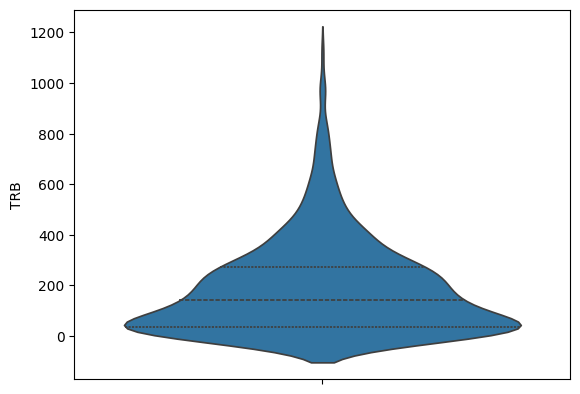

In [ ]:
# visualizing data
sns.violinplot(basketball_data.TRB,inner='quart')

Here I have separated by position so that each one shares the hyperpriors and have different priors, and I graphed a SkewNormal distribution. There are a lot of divergences though and I can see that the distribution doesn't fit my data very well. Judging by the shape, I'm going to try an Exponential distribution instead to get it to fit better

In [ ]:
with pm.Model(coords = bskt_coords) as bskt_model:
    #hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)

    #priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "pos")

    σ = pm.HalfNormal('σ', sigma = 10, dims = "pos")

    α = pm.Exponential('α', lam = 5, dims = "pos")

    # Skew Normal
    _ = pm.SkewNormal('trb', mu = μ[pos_idx], sigma = σ[pos_idx], alpha = α[pos_idx], observed = basketball_data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_bskt = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 176 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='trb'>

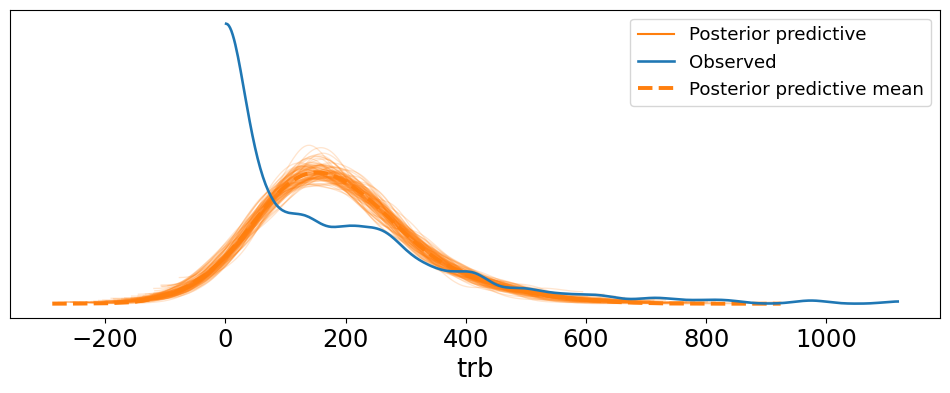

In [ ]:
pm.sample_posterior_predictive(idata_bskt, model=bskt_model, extend_inferencedata=True)
az.plot_ppc(idata_bskt, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Here I used an Exponential distribution for my hierarchical model, and it does fit a lot better with 0 divergences

In [ ]:
with pm.Model(coords = bskt_coords) as bskt_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "pos")

    #exponential
    _ = pm.Exponential('trb', lam = λ[pos_idx], observed = basketball_data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_bskt = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

(0.0, 1000.0)

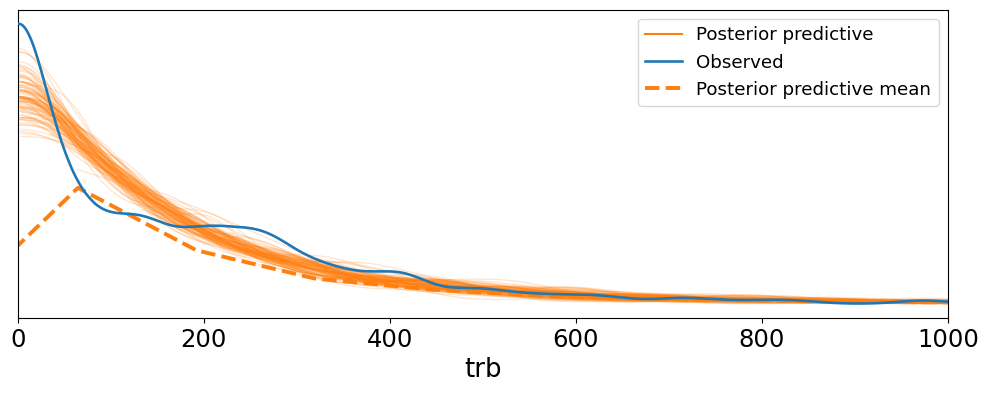

In [ ]:
pm.sample_posterior_predictive(idata_bskt, model=bskt_model, extend_inferencedata=True)
explot = az.plot_ppc(idata_bskt, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
explot.set_xlim(0, 1000)

## Conclusion

Looking at the trace plot for λ, some positions have clear peaks while others are spread out and don't capture a clear pattern. This indicates that the model might be having a hard time predicting TRB for certain positions

(0.0, 0.012)

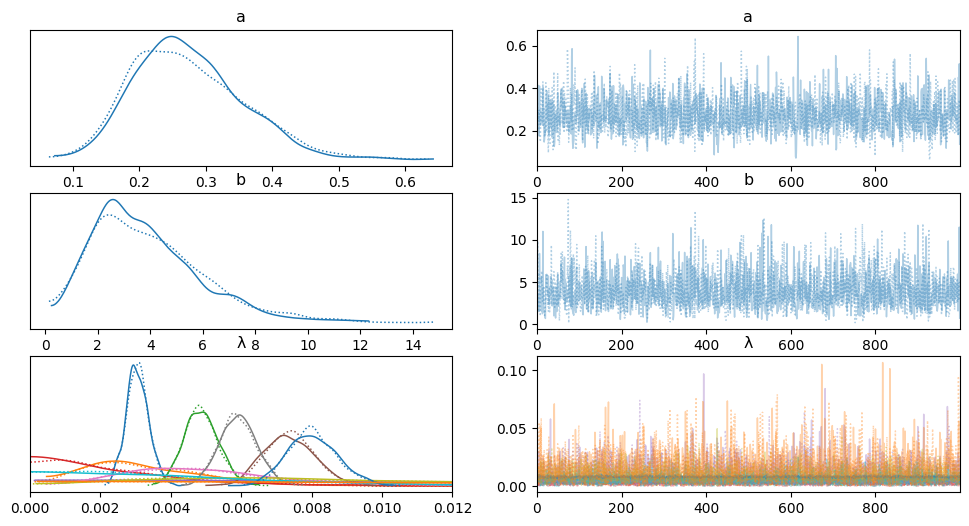

In [ ]:
#limiting the x on graph of the λ to make it easier to read
az.plot_trace(idata_bskt)[2,0].set_xlim([0, .012])

The r-hat values are very close to 1 meaning they are close to ideal. A value below 1.1 indicates the chains are likely converged, which is a good sign that we won't have to run more iterations

In [ ]:
az.rhat(idata_bskt)

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.001
    b        float64 8B 0.9996
    λ        (pos) float64 96B 0.9998 0.9997 1.0 0.9994 ... 1.002 1.001 1.0

Below I created a ridgeplot to visualize the means of the positions, and later I take the reciprocals of each to get the actual TRB prediction for each position

array([<Axes: >], dtype=object)

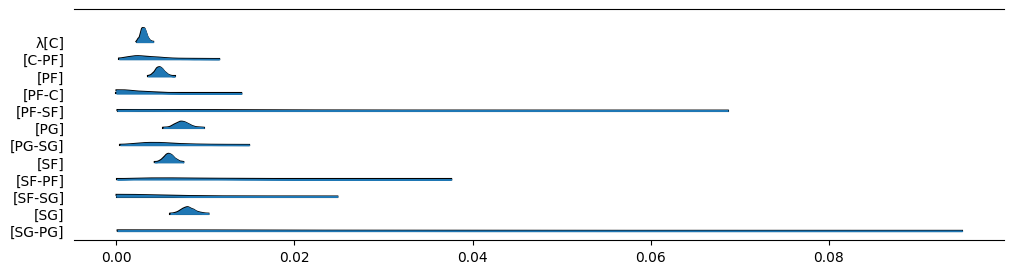

In [ ]:
az.plot_forest(idata_bskt, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In [ ]:

posterior = idata_bskt.posterior
lamda_variable = posterior['λ']
mean_lamda = lamda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lamda.values

#making an array of the reciprocals of the means
new_array = []
for x in mean_array:
  new_array.append(1/x)

#matching up the predictions with respective position

for i in range(len(pos_codes)):
  position = pos_codes[i]
  reciprocal = new_array[i]
  print(f'{position} = {reciprocal}')



C = 326.3526270845791
C-PF = 296.020776050002
PF = 205.3695950132155
PF-C = 394.400408677227
PF-SF = 89.57848577745946
PG = 135.36355042800346
PG-SG = 196.4368551825
SF = 168.73637367734798
SF-PF = 111.04174532038597
SF-SG = 213.5180745081845
SG = 124.49965593749178
SG-PG = 64.73555249152646


Looking at the predictions above, I see that the center and power forward have the greatest predicted TRB%, while shooting guards and point guards have lower predicted TRB%. These predictions seem to match up with reality: because centers and power forwards player closer to the net, they are more likely to get higher rebounds. This is a good indication that our model is working well